In [ ]:
!pip install transformers[torch] evaluate accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TestData = pd.read_csv('/content/drive/MyDrive/NLP/clean_test.csv')
TrainData = pd.read_csv('/content/drive/MyDrive/NLP/clean_train.csv')

print(TestData.shape)
print(TrainData.shape)

(7968, 2)
(45149, 2)


Encode the labels and tokenizing the dataset

In [ ]:
unique_labels = TrainData['Y'].unique()
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

This part of code is related to preproccessing of data, splitting to trian, validate and test data.
Then some operation that must be done to use dataset on BERT model

In [ ]:
def preprocess_function(example):
    return tokenizer(example["X"], truncation=True, padding=True, max_length=512)

train_df, val_df = train_test_split(TrainData, test_size=0.25, random_state=42)

tokenized_train = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
tokenized_val = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)
tokenized_test = Dataset.from_pandas(TestData).map(preprocess_function, batched=True)

tokenized_train = tokenized_train.add_column("labels", [label2id[label] for label in train_df['Y']])
tokenized_val = tokenized_val.add_column("labels", [label2id[label] for label in val_df['Y']])
tokenized_test = tokenized_test.add_column("labels", [label2id[label] for label in TestData['Y']])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/33861 [00:00<?, ? examples/s]

Map:   0%|          | 0/11288 [00:00<?, ? examples/s]

Map:   0%|          | 0/7968 [00:00<?, ? examples/s]

Model definition

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

trainer.save_model("/content/drive/MyDrive/NLP/fine_tuned_bert")

Epoch,Training Loss,Validation Loss,Accuracy
1,1.225200,1.169779,0.647147
2,0.978300,1.129979,0.654235
3,0.804100,1.140417,0.655652


In [ ]:
def evaluate_model(trainer, test_dataset):
    results = trainer.evaluate(eval_dataset=test_dataset)
    print(f"Test Results: {results}")

    predictions, labels, _ = trainer.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.array(test_dataset["labels"])

    accuracy = accuracy_score(true_classes, predicted_classes)
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    return {
        'test_loss': results['eval_loss'],
        'test_accuracy': results['eval_accuracy'],
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

def plot_evaluation_results(metrics):
    labels = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1.2)
    plt.show()

Test Results: {'eval_loss': 1.3145439624786377, 'eval_accuracy': 0.6036646586345381, 'eval_runtime': 126.6543, 'eval_samples_per_second': 62.911, 'eval_steps_per_second': 3.932}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6036646586345381
F1 Score: 0.5880167395748513
Precision: 0.606679099669115
Recall: 0.6036646586345381


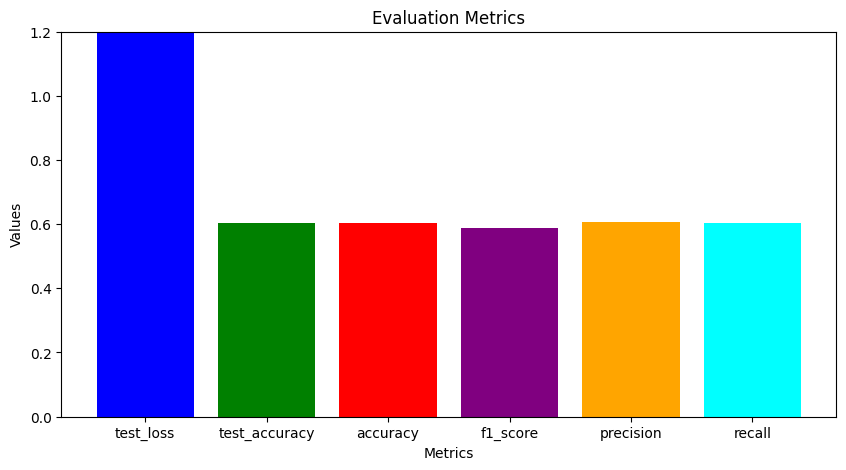

In [ ]:
loaded_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP/fine_tuned_bert")

loaded_trainer = Trainer(
    model=loaded_model,
    args=training_args,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

metrics = evaluate_model(loaded_trainer, tokenized_test)
plot_evaluation_results(metrics)